In [1]:
from tf_util_y import *
from DP import DataLoader
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
d1 = DataLoader(data_name="FFBC400_8_",mode = "reg",p_day = 20,train_prob = 0.8)(p_type = "all")
d2 = DataLoader(data_name="RH400_8_",mode = "reg",p_day = 20,train_prob = 0.8)(p_type = "all")


In [81]:
class model4(MODEL):
    def __init__(self,name = "defmodel4"):
        MODEL.__init__(self,name)
        self.X = tf.placeholder(shape = [None,20,50,18],dtype = tf.float32)
        self.Y = tf.placeholder(shape = [None,3],dtype = tf.float32)
        self.BNX = BN(self.X,name = self.name+"BNX")
        
        self.ZW1 = CONV2D(self.X,[20,1,18,20],name = self.name+"ZW1")
        self.AW1 = ACT(PLUSB(self.ZW1,name = self.name+"bAW1"),name = self.name+"AW1")
        self.S1 = tf.transpose(self.AW1,[0,2,3,1])
        
        self.ZH1 = CONV2D(self.X,[1,50,18,50],name = self.name+"ZH1")
        self.AH1 = ACT(PLUSB(self.ZH1,name=self.name+"bAH1"),name = self.name+"AH1")
        self.S2 = tf.transpose(self.AH1,[0,3,1,2])
        
        self.ZW2 = CONV2D(self.BNX,[20,1,18,20],name = self.name+"ZW2")
        self.AW2 = ACT(PLUSB(self.ZW2,name = self.name + "bAW2"),name = self.name +"AW2")
        self.S3 = tf.transpose(self.AW2,[0,2,3,1])
        
        self.ZH2 = CONV2D(self.BNX,[1,50,18,50],name = self.name+"ZH2")
        self.AH2 = ACT(PLUSB(self.ZH2,name = self.name+"bAH2"),name = self.name+"AH2")
        self.S4 = tf.transpose(self.AH2,[0,3,1,2])
        
        self.CC = tf.concat([self.S1,self.S2,self.S3,self.S4],axis = 3)
        
        self.ZCC = CONV2D(self.CC,[3,3,4,10])
        self.ACC = ACT(PLUSB(self.ZCC,name = self.name+"bACC"),name = self.name+"ACC")
        self.BNACC = BN(self.ACC,name = self.name + "BNACC")
        
        self.ZP = CONV2D(self.ACC,[3,3,10,15],name = self.name + "ZP")
        self.AP = ACT(PLUSB(self.ZP,name = self.name+"bAP"),name = self.name + "AP")
        self.PP = tf.nn.avg_pool(self.AP,ksize=[1,2,2,1],strides=[1,2,2,1],padding="VALID")
        
        self.ZQ = CONV2D(self.BNACC,[3,3,10,15],name = self.name+"ZQ")
        self.AQ = ACT(PLUSB(self.ZQ,name = self.name + "bAQ"),name = self.name + "AQ")
        self.PQ = tf.nn.max_pool(self.AQ,ksize=[1,2,2,1],strides=[1,2,2,1],padding="VALID")
        
        self.CD = tf.concat([self.PP,self.PQ],axis=2)
        
        self.ZCD = CONV2D(self.CD,[7,7,15,20],name = self.name + "ZCD")
        self.ACD = ACT(PLUSB(self.ZCD,name = self.name+"bACD"),name = self.name+"ACD")
        
        self.ZL = CONV2D(self.ACD,[10,10,20,25],name = self.name +"ZL")
        
        self.F0 = tf.contrib.layers.flatten(self.ZL)
        self.AF0 = ACT(PLUSB(self.F0,name = self.name+"bAF0"),name = self.name + "AF0")
        
        self.ZF1 = FC(self.AF0,75,name = self.name + "ZF1")
        self.AF1 = ACT(PLUSB(self.ZF1,name = self.name + "bAF1"),name = self.name+"AF1")
        
        self.OUP = FC(self.AF1,3,name = self.name + "OUP")
        
        self.cost = tf.reduce_mean(tf.squared_difference(self.OUP*100,self.Y*100))
        self.opt = tf.train.AdadeltaOptimizer(30).minimize(self.cost)
        self.init = tf.global_variables_initializer()

In [82]:
tf.reset_default_graph()
m = model4()

In [83]:
m.open()

In [49]:
from functools import reduce
def count_params():
    size = lambda v: reduce(lambda x, y: x*y, v.get_shape().as_list() + [1])
    n = sum(size(v) for v in tf.global_variables())
    print ("Model size: %dK" % (n/1000,))
    return n

In [52]:
count_params()

Model size: 1067K


1067608

<IPython.core.display.Javascript object>


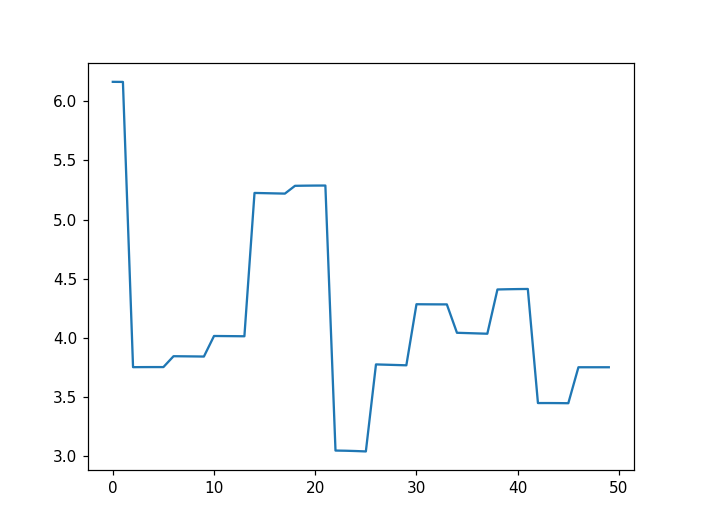

In [55]:
m.train_minib(d1["X_tr"],d1["Y_tr"],bloop=4,bsize = 256,loop = 300)

In [85]:
yy = m.sess.run(m.OUP,feed_dict={m.X:X_ext})#d2["X_te"]})
YY = Y_ext#d2["Y_te"]

In [86]:
abs(yy[:,0]-YY[:,0]).mean(),abs(yy[:,1]-YY[:,1]).mean(),abs(yy[:,2]-YY[:,2]).mean()

(0.024330890041686308, 0.019419050457401259, 0.01951064358685959)

In [87]:
(abs(yy[:,0]-YY[:,0])<0.015).sum()/len(yy), (abs(yy[:,1]-YY[:,1])<0.015).sum()/len(yy), (abs(yy[:,2]-YY[:,2])<0.015).sum()/len(yy)

(0.42105263157894735, 0.52631578947368418, 0.48157894736842105)

In [88]:
yy.max(),yy.min(),yy.mean()

(0.083840422, -0.23818608, -0.012583548)

In [89]:
YY.max(),YY.min(),YY.mean()

(0.27316486161251496, -0.21441774491682064, -0.0014625222308483493)

In [75]:
X_ext,Y_ext = [],[]
for i in range(len(d1["X_tr"])):
    if d1["Y_tr"][i,1] > 0.05 or d1["Y_tr"][i,2] < -0.05:
        X_ext.append(d1["X_tr"][i])
        Y_ext.append(d1["Y_tr"][i])
X_ext = np.stack(X_ext)
Y_ext = np.stack(Y_ext)

In [77]:
X_ext.shape

(380, 20, 50, 18)

<IPython.core.display.Javascript object>


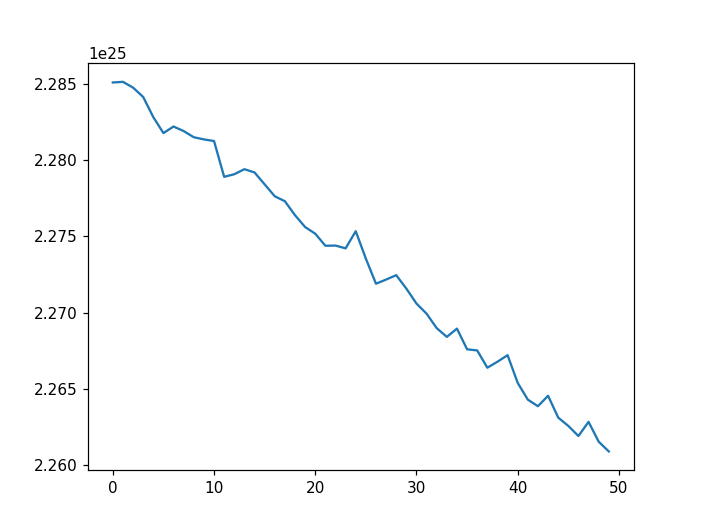

In [90]:
m.train(X_ext,Y_ext,loop = 10000)

In [80]:
m.close()